# Тематическая модель [Постнауки](http://postnauka.ru)

Пример проекта по разбиению коллекции документов на тематические кластеры. В качестве коллекции документов используются лекции проекта просветительского "Постнаука". Ниже для них построена карта авторов, сгруппированных по темам, а также тематический навигатор, в котором для каждой темы выведены наиболее релевантные лекции.

* [Кластеризация](#section1)
    * [0. Считаем данные в объект artm.BatchVectorizer](#step0)
    * [1. Инициализируем модель](#step1)
    * [2. Добавим score](#step2)
    * [3. Построим модель](#step3)
    * [4. Проинтерпретируем темы](#step4)
    * [5. Проанализируем темы](#step5)
    
* [Тематическая карта авторов](#section2)
    * [6. Понижение размерности](#step6)
    * [7. Визуализация](#step7)
    
* [Тематический навигатор](#section3)
    * [8. Создадим простой тематический навигатор по Постнауке](#step8)

In [ ]:
# from google.colab import drive
# drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# !pip install google
# !pip install --upgrade google-api-python-client
# !pip install bigartm
import artm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import math, random
import numpy as np
import pandas as pd
from scipy.spatial import distance, KDTree

from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn
%matplotlib inline
seaborn.set_style('whitegrid', {'axes.grid' : False})

from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances

## Кластеризация <a class="anchor" id="section1"></a>

**0. Считаем данные в объект artm.BatchVectorizer**<a class="anchor" id="step0"></a>

Будем работать с уже подготовленными данными. В коллекции 1 728 документов, размер словаря - 38 467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

In [ ]:
path = r'D:/postnauka/'
input_folder = r'input/'
output_folder = r'output/'
lectures_file = 'lectures.txt'
lectures_path = path + input_folder + lectures_file

In [ ]:
# batch_vectorizer = artm.BatchVectorizer(data_path=lectures_path, 
#                                         data_format="vowpal_wabbit", 
#                                         target_folder=output_folder + 'lectures_batches', 
#                                         batch_size=100)

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path=path + output_folder + 'lectures_batches', 
                                        data_format='batches', 
                                        gather_dictionary=True)

**1. Инициализируем модель**<a class="anchor" id="step1"></a>

Будем строить 29 предметных тем и одну фоновую. 

In [ ]:
T = 30   # зададим количество тем
background_theme = 'bcg'
topic_names = [background_theme] + ['sbj'+str(i) for i in range(1, T)]

model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={'text':1, 'author':1}, cache_theta = True, seed=1)

Соберём словарь с помощью метода gather_dictionary и инициализируем модель.

In [ ]:
dictionary = artm.Dictionary(name='dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize(dictionary)

**2. Добавим score**<a class="anchor" id="step2"></a>

Создадим два измерителя качества artm.TopTokensScore - по одному для каждой модальности.

In [ ]:
model_artm.scores.add(artm.TopTokensScore(name='top_words', num_tokens=15, class_id='text'))
model_artm.scores.add(artm.TopTokensScore(name='top_authors', num_tokens=15, class_id='author'))

**3.Построим модель**<a class="anchor" id="step3"></a>

**Шаг 1.** Сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели.

In [ ]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi_Smooth', 
                                                            tau=1e5, 
                                                            dictionary='dictionary', 
                                                            class_ids=['text'], 
                                                            topic_names=[background_theme])) 

Выполним 30 итераций по коллекции.

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

**Шаг 2.** Добавим разреживающий регуляризатор

In [ ]:
sbjX = ['sbj' + str(i) for i in range(T)]
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi_Sparse', 
                                                            tau=-1e5, 
                                                            dictionary="dictionary", 
                                                            class_ids=['text'],  
                                                            topic_names=sbjX))

Выполним ещё 15 проходов по коллекции.


In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

**4. Проинтерпретируем темы**<a class="anchor" id="step4"></a>

Используя созданные score, выведем топы слов и топы авторов в темах.

Топы слов:

In [ ]:
iterations_num = len(model_artm.score_tracker['top_words'].tokens)
themes_dict_last_iter_words = model_artm.score_tracker['top_words'].tokens[iterations_num-1]

for i in themes_dict_last_iter_words:
    print(i + ':', end=' ')
    for word in themes_dict_last_iter_words[i]:
        print(word, end=', ')
    print()
    print()

bcg: быть, что, это, который, этот, как, они, мочь, такой, очень, для, человек, или, тот, один, 

sbj1: материал, температура, структура, вещество, химический, соединение, поверхность, свойство, химия, давление, углерод, сверхпроводимость, металл, полимер, применение, 

sbj2: политический, государство, власть, царь, партия, церковь, народ, правитель, средневековый, политика, враг, сага, египет, шмитт, государь, 

sbj3: знание, социология, социологический, познание, социолог, предмет, факультет, виктор, аргумент, парадокс, логика, концепт, кафедра, высказывание, прикладной, 

sbj4: мозг, нейрон, мышление, предложение, категория, чтение, взрослый, синтаксический, лицо, обезьяна, детство, шимпанзе, библиотека, игрушка, творческий, 

sbj5: бог, миф, греческий, герой, море, мифология, религия, ритуал, душа, грек, мифологический, гусейнов, божество, шумерский, культ, 

sbj6: русский, текст, словарь, перевод, корпус, гласный, согласный, говор, немецкий, документ, пьеса, иван, академия, древне

Заметим, что в тему "bcg" попали общеупотребительные слова.

Топы авторов:

In [ ]:
iterations_num = len(model_artm.score_tracker["top_authors"].tokens)
themes_dict_last_iter_authors = model_artm.score_tracker["top_authors"].tokens[iterations_num-1]

for i in themes_dict_last_iter_authors:
    print(i + ':', end=' ')
    for word in themes_dict_last_iter_authors[i]:
        print(word.replace('_', ' '), end=', ')
    print()
    print()

bcg: Сергей Неклюдов, Александр Филиппов, Михаил Алексеевский, ПостНаука, Михаил Маяцкий, Алексей Миллер, Михаил Бурцев, Андрей Зорин, Алексей Маслов, Ян Левченко, Борис Миркин, Анатолий Баранов, Татьяна Ребеко, Владимир Каганский, Николай Дронин, 

sbj1: Артем Оганов, Валерий Фокин, Дмитрий Паращук, Валентин Ненайденко, Дмитрий Гольберг, Иван Сорокин, Евгений Гудилин, Владимир Пудалов, Валентин Крапошин, Дмитрий Клинов, Владимир Комлев, Алексей Хохлов, Вадим Бражкин, Евгений Антипов, Сергей Морозов, 

sbj2: Кирилл Мартынов, Александр Марей, Алексей Юдин, Александр Павлов, Михаил Бойцов, Фёдор Успенский, Иван Ладынин, Ольга Тогоева, Рафаэль Арутюнян, Руслан Хестанов, Дина Гусейнова, Александр Воеводский, Юрий Рогулёв, Владимир Малахов, Александр Филиппов, 

sbj3: Виктор Вахштайн, Андрей Лукашов, Максим Демин, Татьяна Клячко, Эмиль Ахмедов, Алексей Котов, Татьяна Котова, Дмитрий Балалыкин, Сергей Зенкин, Максим Кронгауз, Алексей Рубцов, Ян Левченко, Владимир Миронов, Алексей Шмелев, Мих

По топам слов присвоим название каждой теме.

In [ ]:
sbj_topic_labels = ['1. Химия и материаловедение',
                   '2. Политология',
                   '3. Социология',
                   '4. Исследования мозга',
                   '5. Религия и мифология',
                   '6. Русский язык',
                   '7. Антропология',
                   '8. Юриспруденция',
                   '9. Биология',
                   '10. Экология',
                   '11. Психология',
                   '12. Киевская Русь',
                   '13. Наука',
                   '14. Астрономия',
                   '15. Экономика',
                   '16. Отношения и семья',
                   '17. Computer Science',
                   '18. Востоковедение',
                   '19. Генетика',
                   '20. Квантовая механика',
                   '21. Философия',
                   '22. История Европы',
                   '23. СССР',
                   '24. Лингвистика',
                   '25. Физика элементарных частиц',
                   '26. Театр',
                   '27. Астрофизика и теория относительности',
                   '28. Кинематограф',
                   '29. Медицина']
topic_labels = ["0. Фоновая тема"] + sbj_topic_labels

**5. Проанализируем темы**<a class="anchor" id="step5"></a>

Далее будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 

In [ ]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 

theta = model_artm.get_theta()
theta

,http://postnauka.ru/video/47823,http://postnauka.ru/video/47826,http://postnauka.ru/video/47827,http://postnauka.ru/video/47828,http://postnauka.ru/video/47947,http://postnauka.ru/video/47950,http://postnauka.ru/video/47952,http://postnauka.ru/video/47955,http://postnauka.ru/video/48015,http://postnauka.ru/video/48017,http://postnauka.ru/video/48021,http://postnauka.ru/video/48025,http://postnauka.ru/video/48100,http://postnauka.ru/video/48106,http://postnauka.ru/video/48107,http://postnauka.ru/video/48109,http://postnauka.ru/video/48112,http://postnauka.ru/video/48114,http://postnauka.ru/video/48116,http://postnauka.ru/video/48118,http://postnauka.ru/video/48305,http://postnauka.ru/video/48333,http://postnauka.ru/video/48335,http://postnauka.ru/video/48337,http://postnauka.ru/video/48338,http://postnauka.ru/video/48340,http://postnauka.ru/video/48341,http://postnauka.ru/video/48343,http://postnauka.ru/video/48345,http://postnauka.ru/video/48452,http://postnauka.ru/video/48455,http://postnauka.ru/video/48476,http://postnauka.ru/video/48478,http://postnauka.ru/video/48480,http://postnauka.ru/video/48489,http://postnauka.ru/video/48492,http://postnauka.ru/video/48493,http://postnauka.ru/video/48619,http://postnauka.ru/video/48621,http://postnauka.ru/video/48623,...,http://postnauka.ru/video/24436,http://postnauka.ru/video/24440,http://postnauka.ru/video/24445,http://postnauka.ru/video/24447,http://postnauka.ru/video/24449,http://postnauka.ru/video/24451,http://postnauka.ru/video/24457,http://postnauka.ru/video/24460,http://postnauka.ru/video/24461,http://postnauka.ru/video/24467,http://postnauka.ru/video/24473,http://postnauka.ru/video/24505,http://postnauka.ru/video/2456,http://postnauka.ru/video/24932,http://postnauka.ru/video/24945,http://postnauka.ru/video/25085,http://postnauka.ru/video/25087,http://postnauka.ru/video/25093,http://postnauka.ru/video/25095,http://postnauka.ru/video/25097,http://postnauka.ru/video/25101,http://postnauka.ru/video/25104,http://postnauka.ru/video/25119,http://postnauka.ru/video/2518,http://postnauka.ru/video/2520,http://postnauka.ru/video/2522,http://postnauka.ru/video/2524,http://postnauka.ru/video/25253,http://postnauka.ru/video/2526,http://postnauka.ru/video/25261,http://postnauka.ru/video/25267,http://postnauka.ru/video/2527,http://postnauka.ru/video/25278,http://postnauka.ru/video/2528,http://postnauka.ru/video/25281,http://postnauka.ru/video/25283,http://postnauka.ru/video/25286,http://postnauka.ru/video/2529,http://postnauka.ru/video/25290,http://postnauka.ru/video/25292
bcg,6.652788e-01,6.773745e-01,7.054738e-01,8.458000e-01,7.133672e-01,6.663567e-01,7.121939e-01,7.586068e-01,7.859597e-01,7.515001e-01,7.972417e-01,7.929481e-01,8.269138e-01,7.770693e-01,6.611242e-01,6.467692e-01,6.960500e-01,6.238512e-01,7.392411e-01,7.184488e-01,6.910982e-01,7.190754e-01,7.143363e-01,6.885136e-01,6.896579e-01,6.827120e-01,8.273976e-01,7.421249e-01,7.236148e-01,8.318182e-01,7.244807e-01,7.253922e-01,7.026004e-01,6.976123e-01,8.450963e-01,6.702986e-01,7.796577e-01,8.478442e-01,8.084379e-01,8.679895e-01,...,6.448455e-01,6.663681e-01,7.300639e-01,6.298448e-01,6.767511e-01,7.203438e-01,7.487426e-01,7.085264e-01,5.314673e-01,7.526092e-01,6.611698e-01,8.092599e-01,7.051753e-01,7.026935e-01,6.354231e-01,5.851645e-01,6.915789e-01,5.997998e-01,7.092894e-01,6.375700e-01,6.939957e-01,7.655610e-01,6.773610e-01,7.667914e-01,7.478190e-01,0.606317,0.467025,6.704428e-01,0.347564,6.532634e-01,6.942111e-01,4.749048e-01,8.391964e-01,7.444184e-01,5.951116e-01,6.299048e-01,7.035831e-01,4.248492e-01,5.364111e-01,7.507042e-01
sbj1,9.964738e-07,2.604425e-08,6.873984e-04,4.755622e-09,2.357566e-06,2.999705e-09,3.984186e-06,2.148195e-05,1.406505e-09,2.851126e-09,0.000000e+00,2.870599e-11,2.765681e-07,2.388698e-02,3.012145e-01,1.280658e-04,7.740815e-11,5.334977e-03,1.064158e-05,5.158070e-08,1.416859e-05,5.601757e-02,0.000000e+00,1.078940e-02,1.290861e-11,3.121181e-14,6.523774e-03,2.526683e-12,1.034587e-06,2.614503e-14,5.781471e-14,

Матрица $\Phi$ - распределение **P(a|t)**, т.е. вероятность встретить в данной теме данного автора. Иначе говоря, это распределение каждой отдельно взятой темы между авторами: сумма по каждому столбцу (теме) равна 1.

"Обратная" вероятность **P(t|a)** будет означать вероятность того, что данный автор занимается данной темой. Это будет распределение каждого отдельно взятого автора между темами.

In [ ]:
phi_a = model_artm.get_phi(class_ids=['author'])
phi_a

,bcg,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,sbj10,sbj11,sbj12,sbj13,sbj14,sbj15,sbj16,sbj17,sbj18,sbj19,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,sbj29
Михаил_Полуэктов,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.016945
Алексей_Москалев,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.016945
Юрий_Рогулёв,0.000000,0.000000,2.097442e-02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.000000
Алексей_Моисеев,0.005878,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.011934e-09,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.004963e-15,0.0,0.000000
Дмитрий_Баюк,0.011756,0.000000,2.447587e-11,4.452333e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Валерий_Сулейманов,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,6.247976e-02,0.0,0.000000
Эдуард_Пройдаков,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.016031,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.000000,0.0,0.000000,0.030764,0.0,0.0,0.0,0.000000e+00,0.0,0.000000
Виталий_Пальчиков,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.025869,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.000000
Игорь_Курукин,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.054564,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.000000


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение.

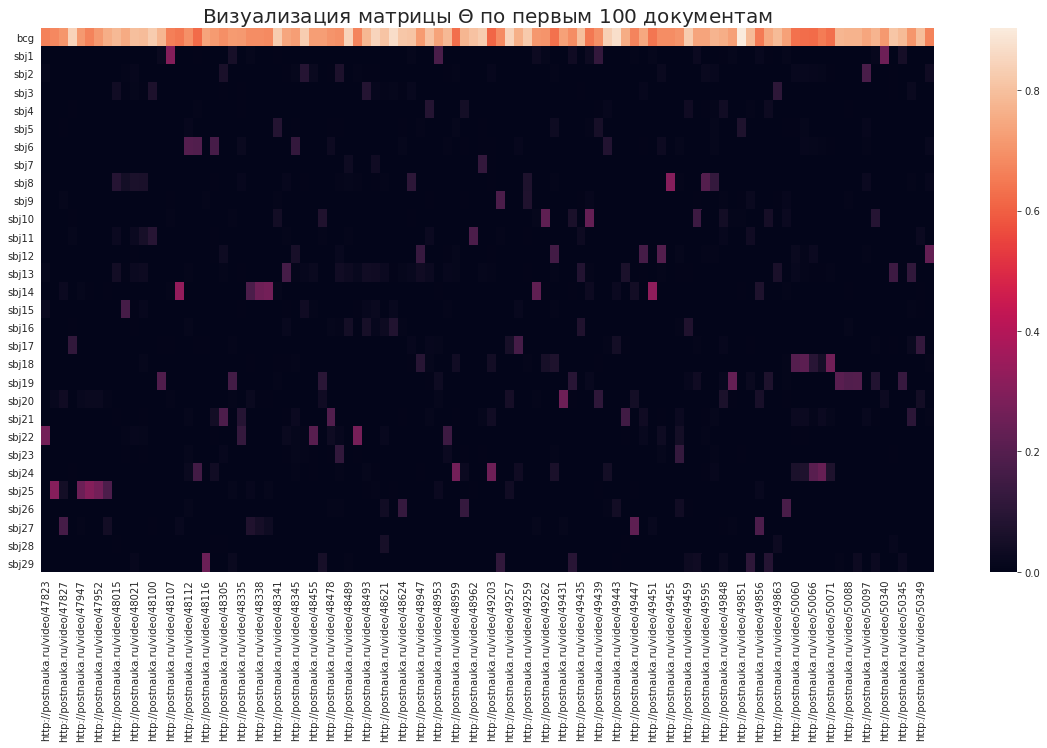

In [ ]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.iloc[:,0:100])
plt.title(r'Визуализация матрицы $\Theta$ по первым 100 документам', fontsize=20)
plt.show()

Посмотрим также на диаграмму для всех документов.

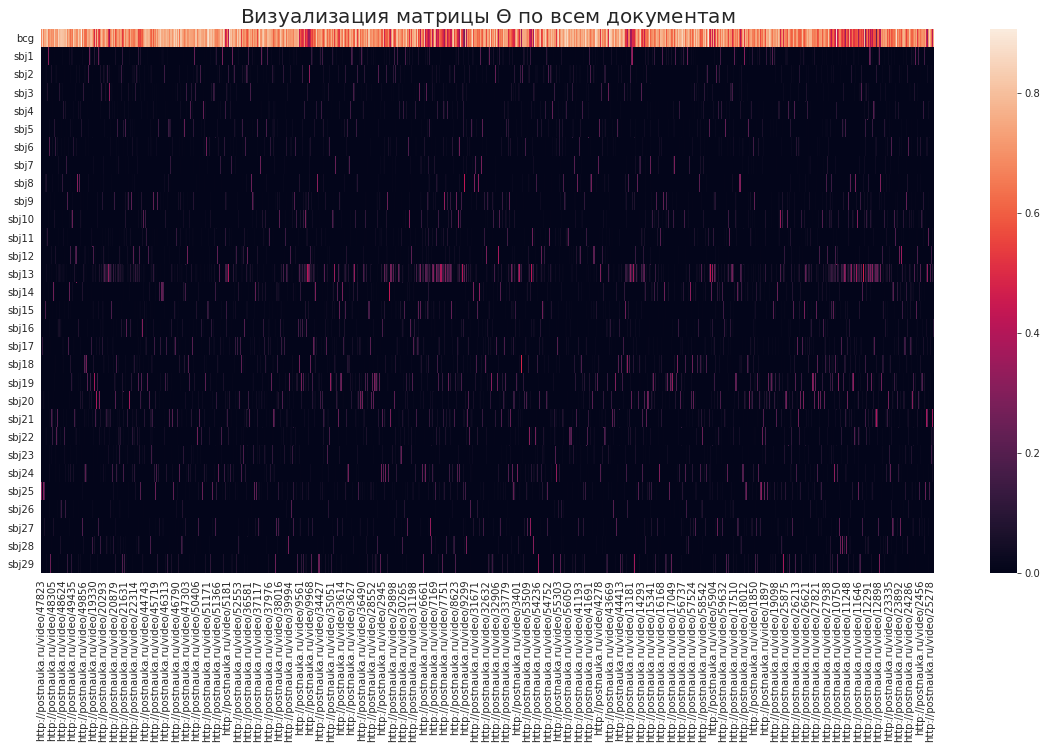

In [ ]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta)
plt.title(r'Визуализация матрицы $\Theta$ по всем документам', fontsize=20)
plt.show()

Как видим, фоновая тема имеет большую вероятность в почти каждом документе. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в коллекции связан с наукой. Дадим этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Теперь Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его размерность. 

In [ ]:
pt = pd.DataFrame(data=theta.sum(axis=1)/theta.shape[1], index=topic_names, columns=['P(t)']).sort_values(by=["P(t)"])
pt

,P(t)
sbj26,0.002922
sbj7,0.004489
sbj28,0.005445
sbj4,0.005968
sbj11,0.006468
sbj23,0.006672
sbj6,0.006721
sbj3,0.007079
sbj16,0.007500
sbj8,0.007649


5 самых популярных тем (не считая фоновую и общенаучную): 

* sbj18 	Востоковедение (практически наравне с "Химией и материаловедением")
* sbj24 	Лингвистика
* sbj21 	Философия
* sbj20 	Квантовая механика
* sbj19   Генетика

3 наименее популярные темы:

* sbj26 	Театр
* sbj7 	Антропология
* sbj28   Кинематограф

Визуализируем матрицу $\Phi$ модальности авторов в виде изображения.

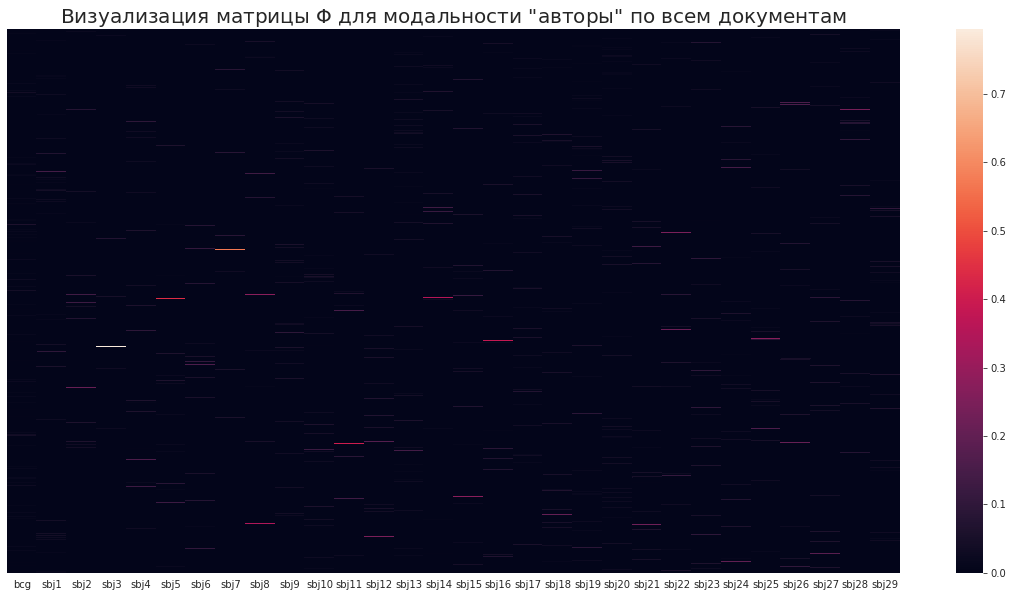

In [ ]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a, yticklabels=False)
plt.title(r'Визуализация матрицы $\Phi$ для модальности "авторы" по всем документам', fontsize=20)
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме.

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитаем, в скольких темах он значим. Найдём авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [ ]:
condition = 0.01
authors = []
subjects_list = list(phi_a.columns)

for i in phi_a.index.values: # i - имя строки
    author = {}
    author['name'] = i
    
    # Мой странный способ фильтрации столбцов по условию
    row = phi_a.loc[[i]].iloc[:,1:]
    to_filter = row[row.loc[[i]] > condition]
    filtered = to_filter.dropna(axis=1, how='all')
    
    themes_raw = list(filtered.columns)
    themes = []
    for i in themes_raw:
        themes.append(sbj_topic_labels[subjects_list.index(i)-1])
    author['themes'] = themes
    author['themes_number'] = len(themes)
    
    authors.append(author)

In [ ]:
for i in authors:
    if i['themes_number'] >= 3:
        print(i['name'].replace('_', ' ') + ': ' + str(i['themes']).strip('[]').replace("'", ""))
        print()

Александр Марей: 2. Политология, 8. Юриспруденция, 22. История Европы

Олег Ауров: 5. Религия и мифология, 23. СССР, 24. Лингвистика

Ольга Вайнштейн: 8. Юриспруденция, 21. Философия, 22. История Европы, 28. Кинематограф

Андрей Журавлев: 5. Религия и мифология, 23. СССР, 26. Театр

Эмиль Ахмедов: 3. Социология, 14. Астрономия, 25. Физика элементарных частиц

Фёдор Успенский: 2. Политология, 8. Юриспруденция, 12. Киевская Русь

Александр Воеводский: 2. Политология, 5. Религия и мифология, 15. Экономика

Дина Гусейнова: 2. Политология, 13. Наука, 21. Философия

Александр Пиперски: 6. Русский язык, 24. Лингвистика, 26. Театр



## Раздел 2. Тематическая карта авторов <a class="anchor" id="section2"></a>

**6. Понижение размерности**<a class="anchor" id="step6"></a>

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный.

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у нас есть и записаны в переменных phi и pt.

In [ ]:
pt_new = pd.DataFrame(data=theta.sum(axis=1)/theta.shape[1], index=topic_names, columns=['P(t)'])
numerators = phi_a * pt_new.transpose().values[0]

den = phi_a * pt_new.transpose().values[0]
denominators = den.sum(axis=1)

for_mult = denominators**(-1)
a_dist = numerators.transpose() * for_mult.values
a_distrib_final = a_dist.transpose()

Проверка: суммы вероятностей по авторам должны быть равны 1. Из-за ошибки вычислений это не выполняется, поэтому зададим требуемую точность - до 3 знака.

In [ ]:
set(round(a_distrib_final.sum(axis=1), 3))

{1.0}

**Метод 1.** MDS (Multidimensional Scaling)

In [ ]:
a_distrib_64 = pd.DataFrame(a_distrib_final, dtype=np.float64) # иначе MDS не распознаёт pairwise_distances(a_distrib_final, metric='cosine') как симметричную матрицу

In [ ]:
MDS_transformed_cos = MDS(random_state = 1, n_components = 2, n_init = 1, max_iter = 100).fit_transform(pairwise_distances(a_distrib_64, metric='cosine'))
pd.DataFrame(MDS_transformed_cos).tail()

,0,1
534,-1.798944,-2.589755
535,-3.518894,-1.993046
536,-3.284976,5.140041
537,0.248009,-0.089238
538,-5.796133,0.935526


Визуализируем найденные двумерные представления.

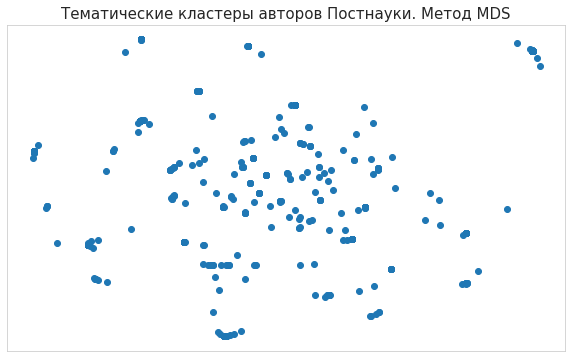

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(MDS_transformed_cos[:, 0], MDS_transformed_cos[:, 1])
plt.title('Тематические кластеры авторов Постнауки. Метод MDS', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.show()

Кластеров не видно (хотя, вероятно, это изменится, если раскрасить график). Попробуем t-SNE.

**Метод 2.** t-SNE (t-distributed Stochastic Neighbor Embedding)

In [ ]:
tsne = TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(pairwise_distances(a_distrib_final, metric='cosine'))

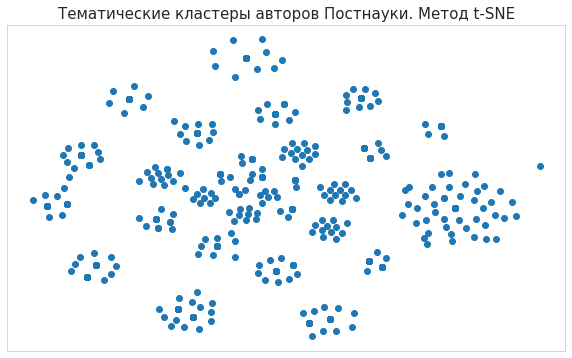

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1])
plt.title('Тематические кластеры авторов Постнауки. Метод t-SNE', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.show()

То, что нужно. Кластеры видны даже без раскрашивания.

NB: TSNE отработал на float32.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy.

In [ ]:
author_themes_frame = pd.DataFrame(a_distrib_final.idxmax(axis=1)).reset_index().rename({'index': 'authors', 0: 'themes'}, axis=1)

In [ ]:
authors_data = pd.merge(author_themes_frame, 
                  pd.DataFrame(data_2d_tsne).rename({0: 'x', 1: 'y'}, axis=1), 
                  left_index=True, 
                  right_index=True)
authors_data

,authors,themes,x,y
0,Михаил_Полуэктов,sbj29,-377.895020,-57.138046
1,Алексей_Москалев,sbj29,-433.072174,-11.326143
2,Юрий_Рогулёв,sbj2,-16.908480,-51.122002
3,Алексей_Моисеев,bcg,355.515778,-74.350258
4,Дмитрий_Баюк,bcg,312.278870,-49.809208
...,...,...,...,...
534,Валерий_Сулейманов,sbj27,214.545959,-219.241089
535,Эдуард_Пройдаков,sbj23,-58.865437,-187.743118
536,Виталий_Пальчиков,sbj20,-38.759136,428.014191
537,Игорь_Курукин,sbj22,52.904858,49.040749


**7. Визуализация**<a class="anchor" id="step7"></a>

Определим необходимый функции.

In [ ]:
def push_from_center(data, x='x', y='y'):
    
    x_half = (data[x].max() - data[x].min()) / 2
    y_half = (data[y].max() - data[y].min()) / 2
    x_center = data[x].max() - x_half
    y_center = data[y].max() - y_half
    new_x = data[x] - x_center
    new_y = data[y] - y_center
    data = data.assign(x = new_x, y = new_y)
    
#     coef = 1.5
#     data = data.assign(x = data[x] * coef, y = data[y] * coef)
    
    param = 5
    for i in list(data.index):
        data[x].loc[i] = data[x].loc[i] * ( 1 + ( param - abs(data[x].loc[i]) / x_half ))
        data[y].loc[i] = data[y].loc[i] * ( 1 + ( param - abs(data[y].loc[i]) / y_half ))
    
    return data

In [ ]:
def get_clusters_centers(data, clusters_col='themes', x='x', y='y'):
    # clusters_col - column with clusters names
    # x - column with x coordinates
    # y - column with y coordinates
    
    centers = {}
    
    for i in data[clusters_col].unique():
        center = data[data[clusters_col]==i][[x, y]].mean()
        centers[i] = center
    
    return pd.DataFrame(centers).transpose().sort_index()

In [ ]:
def get_max_radiuses(centers, coef=0.9):
    # Эта функция возвращает словарь, в котором ключами являются имена кластеров,
    # а значениями - половина расстояния от центра кластера до центра ближайшего кластера,
    # умноженная на коэффициент.
    # centers - DataFrame, в котором индексом являются имена кластеров, колонками - координаты центров кластеров
    
    max_radiuses = {}
    
    distances = pd.DataFrame(distance.cdist(centers.values, centers.values)).replace(0, np.nan)
    pairs = distances.idxmin()
    for i in list(pairs.index):
        max_radiuses[centers.index[i]] = (distances.iloc[i, pairs[i]] / 2) * 0.9
    
    return max_radiuses

In [ ]:
def get_annotations_coords(data, clusters_col='themes', x='x', y='y'):
    
    np.random.seed = 42
    
    data['annot x'] = ''
    data['annot y'] = ''
    data['rad'] = ''
    centers = get_clusters_centers(data) # центры масс кластеров
    max_radiuses = get_max_radiuses(centers, coef=0.9) # половины (или меньше) расстояний до ближайших центров
            
    for cluster in data[clusters_col].unique():
        
        df = data[data[clusters_col]==cluster]
        
        center = centers.loc[cluster]
        max_radius = max_radiuses[cluster]
        min_radius = pd.DataFrame(distance.cdist([center.values], df[[x, y]])).transpose().max().values[0] # аннотации должны быть за пределами облака точек
        
        radiuses_dif = max_radius - min_radius
        levels_number = df.groupby(by=[x, y]).size().max() # количество "уровней", по которым будут
                                                           # распределяться аннотации вокруг кластера
        plotted = []

        for i in list(df.index):
            
            #координаты аннотируемой точки
            point_x = df[x].loc[i]
            point_y = df[y].loc[i]

            repetition = plotted.count([point_x, point_y]) # который раз появляется точка с такими координатами?
            unique = [list(j) for j in df[[x, y]].values].count([point_x, point_y]) == 1 # эта точка уникальная в кластере или нет?

            # координаты вектора, соединяющего центр кластера с точкой
            dif_x = point_x - center[x]
            dif_y = point_y - center[y]
            
            # для каждого уровня вычисляются коэффициенты, на которые нужно умножить минимальный радиус,
            # чтобы "попасть" на этот уровень
            raw_coefs = [(1 / levels_number) * k for k in range(1, levels_number+1)]
            radius_coefs = [(min_radius + t * radiuses_dif) / min_radius for t in raw_coefs]
            
            if unique: # если точка уникальна, аннотация попадает на случайный уровень
                final_coef = min_radius * random.choice(radius_coefs) / distance.euclidean((point_x, point_y), (center['x'], center['y']))
            else: # иначе она попадает на уровень, соответствующий повторению точки
                final_coef = min_radius * radius_coefs[repetition] / distance.euclidean((point_x, point_y), (center['x'], center['y']))
            
            
            data['annot x'].loc[i] = center[x] + dif_x * final_coef
            data['annot y'].loc[i] = center[y] + dif_y * final_coef
            data['rad'].loc[i] = distance.euclidean((center[x], center[y]), (data['annot x'].loc[i], data['annot y'].loc[i]))

            plotted.append([point_x, point_y])
                
    return data

Сначала посмотрим на карту без подписей.

In [ ]:
centers = get_clusters_centers(authors_data, center_type='mass')

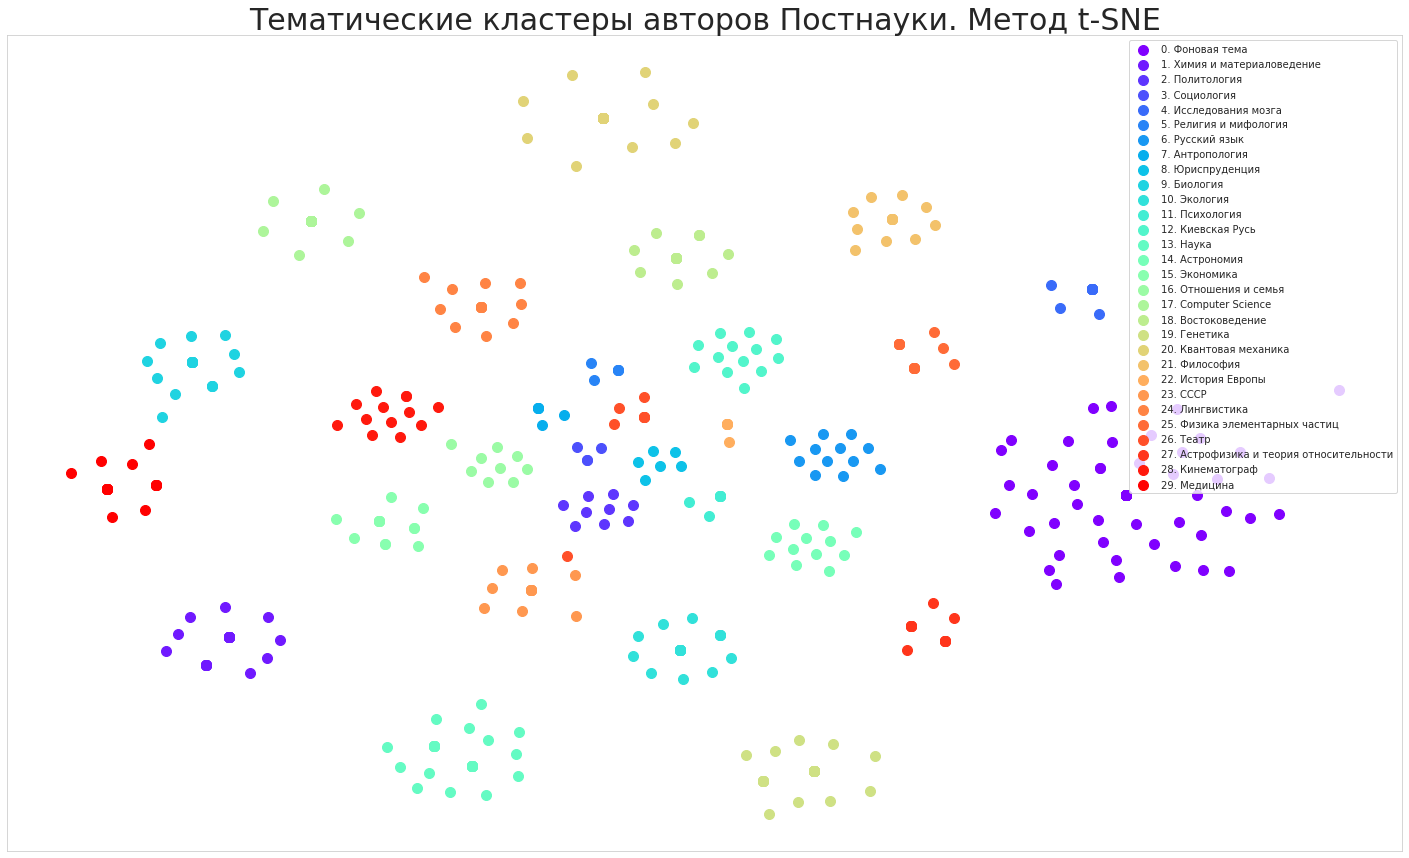

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем

plt.figure(figsize=(25, 15))

# Точки
for y, color in zip(topic_names, colors):
    c=color.reshape(1,-1) # библиотека требует представлять цвет как 2D массив 
    plt.scatter(authors_data[authors_data['themes'].values==y]['x'], 
                authors_data[authors_data['themes'].values==y]['y'], 
                c=c, 
                label=str(y), 
                s=100,
                alpha=1)

# plt.scatter(centers['x'], centers['y'])
    
plt.title('Тематические кластеры авторов Постнауки. Метод t-SNE', fontsize=30)
plt.legend(topic_labels)
plt.xticks([])
plt.yticks([])
plt.show()

# plt.savefig(fname='Тематические кластеры Постнауки.pdf', quality=100)

Симпатично. Теперь попробуем добавить подписи.

Видно, что в центре точки скучены. Это может привести к том, что подписи будут накладываться друг на друга. Чтобы этого не произошло, применим преобразование, которое отдалит точки от центра, но при этом несильно изменит общую картину.

Затем рассчитаем координаты подписей и стрелок.

In [ ]:
authors_data = push_from_center(authors_data)

In [ ]:
authors_data = get_annotations_coords(authors_data)

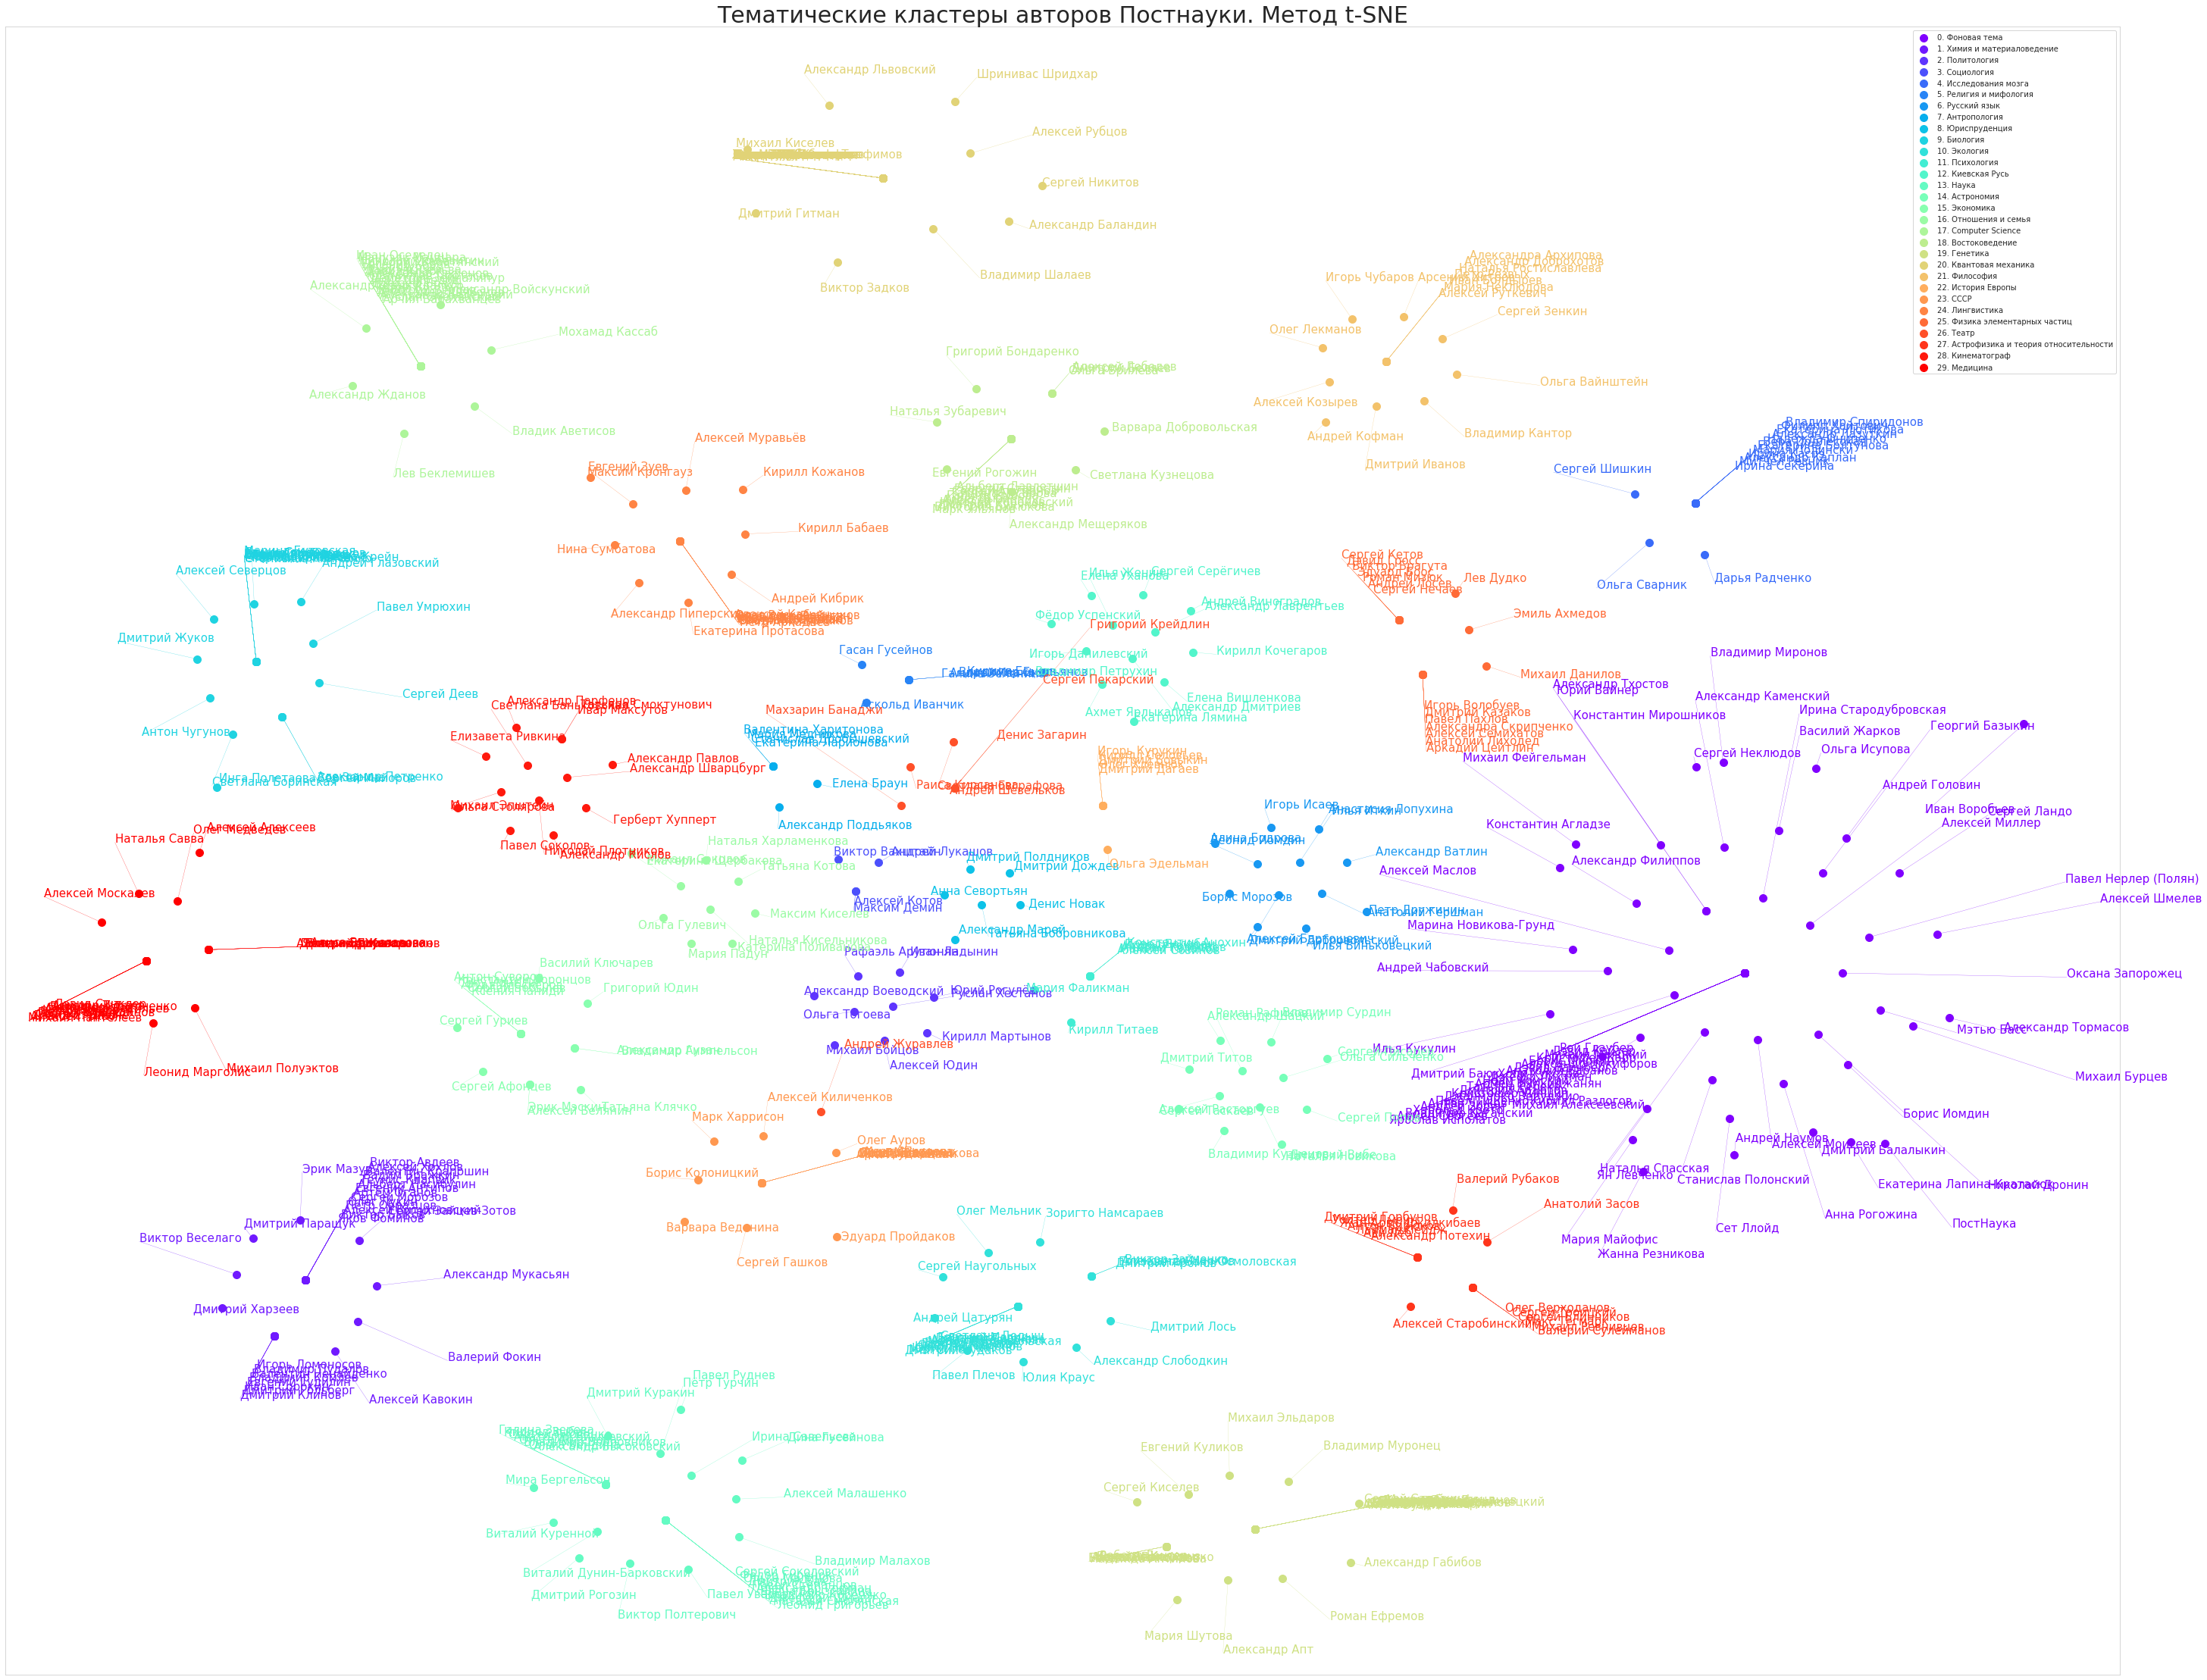

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем

plt.figure(figsize=(50, 40))

# Точки
for theme, color in zip(topic_names, colors):
    
    df = authors_data[authors_data['themes']==theme]
    
    c=color.reshape(1,-1) # библиотека требует представлять цвет как 2D массив 
    plt.scatter(df['x'], df['y'], c=c, label=str(theme), s=100, alpha=1)

    for i in list(df.index):

        author = df['authors'].loc[i].replace('_', ' ')
        point_x = df['x'].loc[i]
        point_y = df['y'].loc[i]
        annot_x = df['annot x'].loc[i]
        annot_y = df['annot y'].loc[i]

        plt.arrow(point_x, point_y, annot_x-point_x, annot_y-point_y, alpha=0.4, linewidth=0.3, color=color)
        plt.annotate(author, xy=(point_x, point_y), xytext=(annot_x, annot_y), fontsize=15, color=color)    

# plt.scatter(centers['x'], centers['y'])

plt.title('Тематические кластеры авторов Постнауки. Метод t-SNE', fontsize=30)
plt.legend(topic_labels)
plt.xticks([])
plt.yticks([])
plt.savefig(fname=path + output_folder + 'Тематические кластеры Постнауки.pdf', quality=100)
plt.show()

Подписи всё же накладываются друг на друга. В идеале нужно делать интерактивную визуализацию, в которой подпись точки появляется при наведении курсора.

Посмотрим ещё на отдельно взятый кластер.

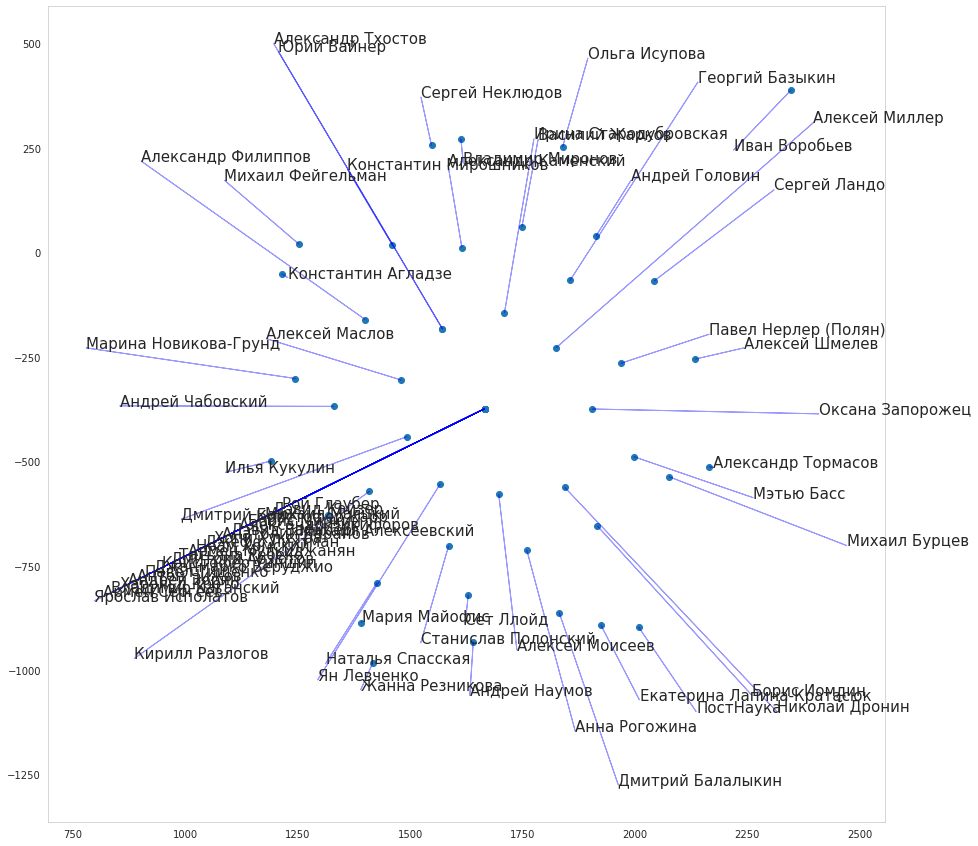

In [ ]:
data = authors_data[authors_data['themes']=='bcg']

plt.figure(figsize=(15, 15))
plt.scatter(data['x'], data['y'])
plt.scatter(data['annot x'], data['annot y'], alpha=0)
# plt.scatter(center['x'], center['y'])

for i in list(data.index):
    
    author = data['authors'].loc[i].replace('_', ' ')
    point_x = data['x'].loc[i]
    point_y = data['y'].loc[i]
    annot_x = data['annot x'].loc[i]
    annot_y = data['annot y'].loc[i]
    
    plt.arrow(point_x, point_y, annot_x-point_x, annot_y-point_y, alpha=0.4, linewidth=1, color='blue')
    plt.annotate(author, xy=(point_x, point_y), xytext=(annot_x, annot_y), fontsize=15)
        
plt.show()


## Тематический навигатор <a class="anchor" id="section3"></a>

**8. Создадим простой тематический навигатор по Постнауке**<a class="anchor" id="step8"></a>

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на количество элементов в ней (в числителе и перед суммированием в знаменателе), чтобы оценить распределение. 

**NB**

$\Theta$ - матрица распределений $p(t|d)$ каждого отдельно взятого документа между темами. Сумма элементов по столбцам (т.е. документам) равна 1.

Вообще, можно пользоваться следующими мнемониками:
- $p(a|t)$ - "авторы в теме"
- $p(t|a)$ - "темы автора"

- $p(t|d)$ - "темы в документе" - имеется (матрица $\Theta$)
- $p(d|t)$ - "документы в теме" - нужной найти

Первое обозначение ставится во множественное число, второе - в единственное.



In [ ]:
numerators = theta / theta.shape[1]

den = theta / theta.shape[1]
denominators = den.sum(axis=1)

for_mult = denominators**(-1)
d_distrib = numerators.transpose() * for_mult.values
d_distrib_final = d_distrib.transpose()
d_distrib_final.tail()

,http://postnauka.ru/video/47823,http://postnauka.ru/video/47826,http://postnauka.ru/video/47827,http://postnauka.ru/video/47828,http://postnauka.ru/video/47947,http://postnauka.ru/video/47950,http://postnauka.ru/video/47952,http://postnauka.ru/video/47955,http://postnauka.ru/video/48015,http://postnauka.ru/video/48017,http://postnauka.ru/video/48021,http://postnauka.ru/video/48025,http://postnauka.ru/video/48100,http://postnauka.ru/video/48106,http://postnauka.ru/video/48107,http://postnauka.ru/video/48109,http://postnauka.ru/video/48112,http://postnauka.ru/video/48114,http://postnauka.ru/video/48116,http://postnauka.ru/video/48118,http://postnauka.ru/video/48305,http://postnauka.ru/video/48333,http://postnauka.ru/video/48335,http://postnauka.ru/video/48337,http://postnauka.ru/video/48338,http://postnauka.ru/video/48340,http://postnauka.ru/video/48341,http://postnauka.ru/video/48343,http://postnauka.ru/video/48345,http://postnauka.ru/video/48452,http://postnauka.ru/video/48455,http://postnauka.ru/video/48476,http://postnauka.ru/video/48478,http://postnauka.ru/video/48480,http://postnauka.ru/video/48489,http://postnauka.ru/video/48492,http://postnauka.ru/video/48493,http://postnauka.ru/video/48619,http://postnauka.ru/video/48621,http://postnauka.ru/video/48623,...,http://postnauka.ru/video/24436,http://postnauka.ru/video/24440,http://postnauka.ru/video/24445,http://postnauka.ru/video/24447,http://postnauka.ru/video/24449,http://postnauka.ru/video/24451,http://postnauka.ru/video/24457,http://postnauka.ru/video/24460,http://postnauka.ru/video/24461,http://postnauka.ru/video/24467,http://postnauka.ru/video/24473,http://postnauka.ru/video/24505,http://postnauka.ru/video/2456,http://postnauka.ru/video/24932,http://postnauka.ru/video/24945,http://postnauka.ru/video/25085,http://postnauka.ru/video/25087,http://postnauka.ru/video/25093,http://postnauka.ru/video/25095,http://postnauka.ru/video/25097,http://postnauka.ru/video/25101,http://postnauka.ru/video/25104,http://postnauka.ru/video/25119,http://postnauka.ru/video/2518,http://postnauka.ru/video/2520,http://postnauka.ru/video/2522,http://postnauka.ru/video/2524,http://postnauka.ru/video/25253,http://postnauka.ru/video/2526,http://postnauka.ru/video/25261,http://postnauka.ru/video/25267,http://postnauka.ru/video/2527,http://postnauka.ru/video/25278,http://postnauka.ru/video/2528,http://postnauka.ru/video/25281,http://postnauka.ru/video/25283,http://postnauka.ru/video/25286,http://postnauka.ru/video/2529,http://postnauka.ru/video/25290,http://postnauka.ru/video/25292
sbj25,6.305080e-17,1.415496e-02,2.134016e-03,1.204129e-14,1.146876e-02,1.406462e-02,1.237036e-02,8.501182e-03,9.890852e-11,1.261334e-09,7.160128e-09,3.389557e-07,3.019901e-06,1.328615e-04,3.002081e-07,2.835134e-08,8.984108e-10,1.289797e-09,3.897963e-13,3.803668e-08,5.056187e-11,5.270045e-04,1.024967e-12,0.000817,2.462040e-05,6.236304e-04,1.887117e-11,6.521062e-11,2.462720e-09,5.246018e-09,1.171564e-08,9.044404e-12,1.971185e-13,3.739956e-06,3.546450e-10,2.366939e-08,2.413154e-04,3.748784e-04,2.874129e-09,1.684414e-04,...,1.209955e-08,3.857507e-15,0.000000e+00,1.434304e-03,0.000710,0.000000e+00,0.000000e+00,4.742029e-04,0.000178,3.021006e-11,1.979856e-04,1.198546e-11,6.525408e-03,0.000543,1.086053e-08,0.000000e+00,0.000000,2.785654e-09,4.559971e-05,0.000000e+00,0.000000e+00,0.000143,1.347639e-08,7.263417e-08,1.093600e-02,0.0,0.0,1.089229e-07,0.0,3.527606e-14,0.000000,0.0,0.007279,0.000544,2.459093e-04,3.319771e-13,1.580954e-10,0.0,0.000000,0.000000e+00
sbj26,5.452209e-04,9.279287e-11,2.783979e-10,1.145786e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.611877e-10,2.581137e-09,1.520760e-16,1.082125e-06,5.644221e-04,6.817970e-15,0.000000e+00,2.233630e-03,6.936397e-05,2.462743e-12,7.266681e-10,2.262128e-13,0.000000e+00,2.182534e-13,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.847299e-08,0.000000e+00,8.407115e-11,0.000000e+00,1.470809e-16,2.006177e-03,1.818383e-03,5.220933e-04,7.030390e-06,7.491288e

Проверка: сумма вероятностей по темам должны быть равны 1. Из-за ошибки вычислений это не выполняется, поэтому зададим требуемую точность - до 3 знака.

In [ ]:
set(round(d_distrib_final.sum(axis=1), 3))

{1.0}

В цикле для каждой темы выведем её заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов.

In [ ]:
for i in range(T-1):
    
    # Заголовок
    display(HTML(u'<h4>{}</h4>'.format(sbj_topic_labels[i])))
    
    # Топ-10 слов
    words = str()
    for word in themes_dict_last_iter_words[topic_names[i+1]]:
        words = words + ' ' + word
    display(HTML(u'<font color="green">{}</font>'.format(str(words).strip('[]'))))
    
    # Топ-10 документов
    top = 10
    current_topic = d_distrib_final.loc[[topic_names[i+1]], :] # выбираем строку матрицы (тему)
    pd_series = pd.Series(current_topic.values[0]) # превращаем её в Series
    for i in pd_series.sort_values(axis=0, ascending=False).index[:top]: # передаём в цикл упорядоченный индекс Series
        display(HTML(u'<a href="{}">Видео #{}</a>'.format(str(current_topic.columns[i]), i+1))) # Выводим элементы строки матрицы по верхним индексам Series
    print()

Теперь удобно находить видео на интересующие темы.